# Formate Beads Experiment Design - Integrated Model

This notebook contains a complete model for designing formate bead experiments with bacterial cultures. It integrates:
- **Bead release kinetics** (M07 and M03 beads)
- **Bacterial growth** (Monod kinetics)
- **Substrate consumption**
- **Constant substrate maintenance** (automated bead scheduling)

The model calculates how many beads to add each day to maintain constant substrate concentration despite bacterial consumption.

## 1. Import Required Libraries

Import all necessary libraries for numerical calculations, differential equations, and plotting.

In [75]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from typing import Dict, List, Optional

# Configure matplotlib for inline plotting
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

## 3. Process Bead Release Data

Apply correction for linear interpolation and validate against physical bead properties.

## 2. Experiment Configuration

**Configure all experimental parameters here.** All subsequent cells will use these values.

Modify this cell to run different scenarios:
- Update bead release profiles (empirical measurements)
- Adjust Monod kinetics parameters for your bacterial strain
- Change culture volume and target substrate concentration
- Set initial conditions and experiment duration

In [86]:
# ============================================================================
# EXPERIMENT CONFIGURATION - MODIFY PARAMETERS HERE
# ============================================================================

# ---- Formate Properties ----
FORMATE_MW = 68  # mg/mmol (molecular weight of formate)

# ---- Bead Physical Properties ----
M07_FORMATE_CONTENT = 80  # mg formate per M07 bead
M03_FORMATE_CONTENT = 60  # mg formate per M03 bead

# ---- Empirical Bead Release Data (mmol/day) ----
# M07 beads: High initial release, decreasing over 7 days
M07_EMPIRICAL = {
    1: 0.588,  # Day 1: High release
    2: 0.22,
    3: 0.117,
    4: 0.088,
    5: 0.07,
    6: 0.058,
    7: 0.029   # Day 7: Low release
}

# M03 beads: More sustained release profile
M03_EMPIRICAL = {
    1: 0.44,   # Day 1: Moderate release
    2: 0.17,
    3: 0.088,
    4: 0.07,
    5: 0.058,
    6: 0.029,
    7: 0.014   # Day 7: Still releasing
}

# ---- Culture Parameters ----
VOLUME = 1.0  # Culture volume (Liters)

# ---- Monod Kinetics Parameters ----
MONOD_PARAMS = {
    'mu_max': 1,        # Maximum growth rate (1/day)
    'K_s': 20.0,        # Half-saturation constant (mmol/L)
    'Y_xs': 0.0165      # Yield coefficient (OD per mmol/L substrate)
                        # Note: Lower than glucose (0.2) due to formate's lower energy content
}

# ---- Target Substrate Control ----
TARGET_CONCENTRATION = 20.0  # Target substrate concentration (mmol/L)
TOLERANCE = 0.1              # Acceptable deviation as fraction (0.1 = ±10%)

# ---- Initial Conditions ----
INITIAL_OD = 0.1            # Initial bacterial optical density
EXPERIMENT_DAYS = 7          # Total experiment duration (days)

# ---- Simulation Parameters ----
SIMULATION_DT = 0.01         # Time step for numerical integration (days)

# ============================================================================
# DISPLAY CONFIGURATION
# ============================================================================
print("=" * 70)
print("EXPERIMENT CONFIGURATION")
print("=" * 70)

print("\n📦 Bead Properties:")
print(f"  M07 formate content: {M07_FORMATE_CONTENT} mg/bead")
print(f"  M03 formate content: {M03_FORMATE_CONTENT} mg/bead")
print(f"  M07 total release: {sum(M07_EMPIRICAL.values()):.4f} mmol = {sum(M07_EMPIRICAL.values())*FORMATE_MW:.2f} mg")
print(f"  M03 total release: {sum(M03_EMPIRICAL.values()):.4f} mmol = {sum(M03_EMPIRICAL.values())*FORMATE_MW:.2f} mg")

print("\n🧫 Culture Parameters:")
print(f"  Volume: {VOLUME} L")
print(f"  Initial OD: {INITIAL_OD}")
print(f"  Duration: {EXPERIMENT_DAYS} days")

print("\n🦠 Monod Kinetics:")
print(f"  μ_max (max growth rate): {MONOD_PARAMS['mu_max']} 1/day")
print(f"  K_s (half-saturation): {MONOD_PARAMS['K_s']} mmol/L")
print(f"  Y_xs (yield coefficient): {MONOD_PARAMS['Y_xs']} OD per mmol/L")

print("\n🎯 Substrate Control:")
print(f"  Target concentration: {TARGET_CONCENTRATION} mmol/L")
print(f"  Tolerance: ±{TOLERANCE*100:.0f}% ({TARGET_CONCENTRATION*(1-TOLERANCE):.1f} - {TARGET_CONCENTRATION*(1+TOLERANCE):.1f} mmol/L)")

print("\n⚙️  Simulation:")
print(f"  Time step (dt): {SIMULATION_DT} days")

print("\n" + "=" * 70)
print("✓ Configuration loaded successfully!")
print("=" * 70)

EXPERIMENT CONFIGURATION

📦 Bead Properties:
  M07 formate content: 80 mg/bead
  M03 formate content: 60 mg/bead
  M07 total release: 1.1700 mmol = 79.56 mg
  M03 total release: 0.8690 mmol = 59.09 mg

🧫 Culture Parameters:
  Volume: 1.0 L
  Initial OD: 0.1
  Duration: 7 days

🦠 Monod Kinetics:
  μ_max (max growth rate): 1 1/day
  K_s (half-saturation): 20.0 mmol/L
  Y_xs (yield coefficient): 0.0165 OD per mmol/L

🎯 Substrate Control:
  Target concentration: 20.0 mmol/L
  Tolerance: ±10% (18.0 - 22.0 mmol/L)

⚙️  Simulation:
  Time step (dt): 0.01 days

✓ Configuration loaded successfully!


In [87]:
# ============================================================================
# BEAD RELEASE PROFILE CORRECTION
# ============================================================================
# This cell processes the empirical bead release data from the configuration
# above and corrects it for linear interpolation to ensure that the integral
# of the interpolated curve matches the empirical total release.
# ============================================================================

def correct_for_linear_interpolation(empirical_profile):
    """
    Adjust release rates so that the integral of linear interpolation
    matches the discrete sum of empirical measurements.
    
    When we linearly interpolate between daily points, the integral
    (area under the curve) differs from the discrete sum. This function
    calculates a scaling factor to correct for this.
    
    Args:
        empirical_profile (dict): Measured daily release rates
        
    Returns:
        dict: Corrected release rates for use with linear interpolation
    """
    days = sorted(empirical_profile.keys())
    
    # Calculate what the integral WOULD BE with current values
    integral = 0.0
    for i in range(len(days) - 1):
        day1 = days[i]
        day2 = days[i + 1]
        rate1 = empirical_profile[day1]
        rate2 = empirical_profile[day2]
        # Trapezoidal area
        area = 0.5 * (rate1 + rate2) * (day2 - day1)
        integral += area
    
    # Add final day (triangle to zero)
    last_day = days[-1]
    last_rate = empirical_profile[last_day]
    integral += 0.5 * last_rate * 1
    
    # Calculate what the discrete sum IS
    discrete_sum = sum(empirical_profile.values())
    
    # Calculate scaling factor needed
    scaling_factor = discrete_sum / integral if integral > 0 else 1.0
    
    # Apply scaling to all rates
    corrected_profile = {day: rate * scaling_factor 
                        for day, rate in empirical_profile.items()}
    
    return corrected_profile, scaling_factor

# Apply correction to get profiles suitable for linear interpolation
M07_BEAD_RELEASE, m07_scale = correct_for_linear_interpolation(M07_EMPIRICAL)
M03_BEAD_RELEASE, m03_scale = correct_for_linear_interpolation(M03_EMPIRICAL)

print(f"✓ Release profiles corrected for linear interpolation")
print(f"  M07 scaling factor: {m07_scale:.4f} ({(m07_scale-1)*100:+.1f}%)")
print(f"  M03 scaling factor: {m03_scale:.4f} ({(m03_scale-1)*100:+.1f}%)")

# Validation checks
# Check 1: Verify empirical data sums
m07_empirical_sum = sum(M07_EMPIRICAL.values())
m03_empirical_sum = sum(M03_EMPIRICAL.values())

if abs(m07_empirical_sum - 1.17) > 0.01:
    raise ValueError(f"M07 empirical profile sums to {m07_empirical_sum:.4f} mmol, expected 1.17 mmol")

if abs(m03_empirical_sum - 0.87) > 0.01:
    raise ValueError(f"M03 empirical profile sums to {m03_empirical_sum:.4f} mmol, expected 0.87 mmol")

# Check 2: Validate against bead formate content (from configuration)
m07_total_mg = m07_empirical_sum * FORMATE_MW
m03_total_mg = m03_empirical_sum * FORMATE_MW

m07_percent_released = (m07_total_mg / M07_FORMATE_CONTENT) * 100
m03_percent_released = (m03_total_mg / M03_FORMATE_CONTENT) * 100

print("\n" + "=" * 60)
print("EMPIRICAL DATA VALIDATION")
print("=" * 60)
print(f"\nM07 Beads (Empirical):")
print(f"  Total release over 7 days: {m07_empirical_sum:.4f} mmol = {m07_total_mg:.2f} mg")
print(f"  Formate content per bead: {M07_FORMATE_CONTENT} mg")
print(f"  Percent released: {m07_percent_released:.1f}%")

print(f"\nM03 Beads (Empirical):")
print(f"  Total release over 7 days: {m03_empirical_sum:.4f} mmol = {m03_total_mg:.2f} mg")
print(f"  Formate content per bead: {M03_FORMATE_CONTENT} mg")
print(f"  Percent released: {m03_percent_released:.1f}%")

# Warn if release exceeds bead capacity
if m07_total_mg > M07_FORMATE_CONTENT:
    print(f"  ⚠ WARNING: M07 release ({m07_total_mg:.2f} mg) exceeds bead capacity ({M07_FORMATE_CONTENT} mg)!")
if m03_total_mg > M03_FORMATE_CONTENT:
    print(f"  ⚠ WARNING: M03 release ({m03_total_mg:.2f} mg) exceeds bead capacity ({M03_FORMATE_CONTENT} mg)!")

# Check 3: Validate interpolated linear release integral
# The integral of linear interpolation between daily points should equal the sum of daily releases
# For linear interpolation: integral = sum of trapezoidal areas
print("\n" + "=" * 60)
print("INTERPOLATION VALIDATION")
print("=" * 60)

def validate_interpolated_integral(release_profile, empirical_profile, bead_name):
    """
    Calculate the integral of the linearly interpolated release rate
    and verify it matches the empirical discrete sum.
    """
    days = sorted(release_profile.keys())
    
    # Calculate integral using trapezoidal rule
    integral = 0.0
    for i in range(len(days) - 1):
        day1 = days[i]
        day2 = days[i + 1]
        rate1 = release_profile[day1]
        rate2 = release_profile[day2]
        
        # Trapezoidal area for this segment
        area = 0.5 * (rate1 + rate2) * (day2 - day1)
        integral += area
    
    # Add the final day (triangle from last rate to 0)
    last_day = days[-1]
    last_rate = release_profile[last_day]
    integral += 0.5 * last_rate * 1
    
    # Compare with empirical discrete sum (the target)
    empirical_sum = sum(empirical_profile.values())
    
    # Calculate difference
    difference = abs(integral - empirical_sum)
    percent_error = (difference / empirical_sum) * 100 if empirical_sum > 0 else 0
    
    print(f"\n{bead_name} Beads:")
    print(f"  Empirical sum (target):      {empirical_sum:.4f} mmol")
    print(f"  Corrected rates sum:         {sum(release_profile.values()):.4f} mmol")
    print(f"  Interpolated integral:       {integral:.4f} mmol")
    print(f"  Error vs empirical:          {difference:.4f} mmol ({percent_error:.2f}%)")
    
    if percent_error < 0.1:
        print(f"  ✓ Excellent match! (error < 0.1%)")
    elif percent_error < 1.0:
        print(f"  ✓ Good match (error < 1%)")
    else:
        print(f"  ⚠ WARNING: Error exceeds 1%!")
    
    return integral, empirical_sum, difference

# Validate both bead types
m07_integral, m07_empirical, m07_diff = validate_interpolated_integral(
    M07_BEAD_RELEASE, M07_EMPIRICAL, "M07"
)
m03_integral, m03_empirical, m03_diff = validate_interpolated_integral(
    M03_BEAD_RELEASE, M03_EMPIRICAL, "M03"
)

print("\n" + "=" * 60)
print("✓ Interpolation validation complete!")
print("=" * 60)

✓ Release profiles corrected for linear interpolation
  M07 scaling factor: 1.3356 (+33.6%)
  M03 scaling factor: 1.3390 (+33.9%)

EMPIRICAL DATA VALIDATION

M07 Beads (Empirical):
  Total release over 7 days: 1.1700 mmol = 79.56 mg
  Formate content per bead: 80 mg
  Percent released: 99.5%

M03 Beads (Empirical):
  Total release over 7 days: 0.8690 mmol = 59.09 mg
  Formate content per bead: 60 mg
  Percent released: 98.5%

INTERPOLATION VALIDATION

M07 Beads:
  Empirical sum (target):      1.1700 mmol
  Corrected rates sum:         1.5627 mmol
  Interpolated integral:       1.1700 mmol
  Error vs empirical:          0.0000 mmol (0.00%)
  ✓ Excellent match! (error < 0.1%)

M03 Beads:
  Empirical sum (target):      0.8690 mmol
  Corrected rates sum:         1.1636 mmol
  Interpolated integral:       0.8690 mmol
  Error vs empirical:          0.0000 mmol (0.00%)
  ✓ Excellent match! (error < 0.1%)

✓ Interpolation validation complete!


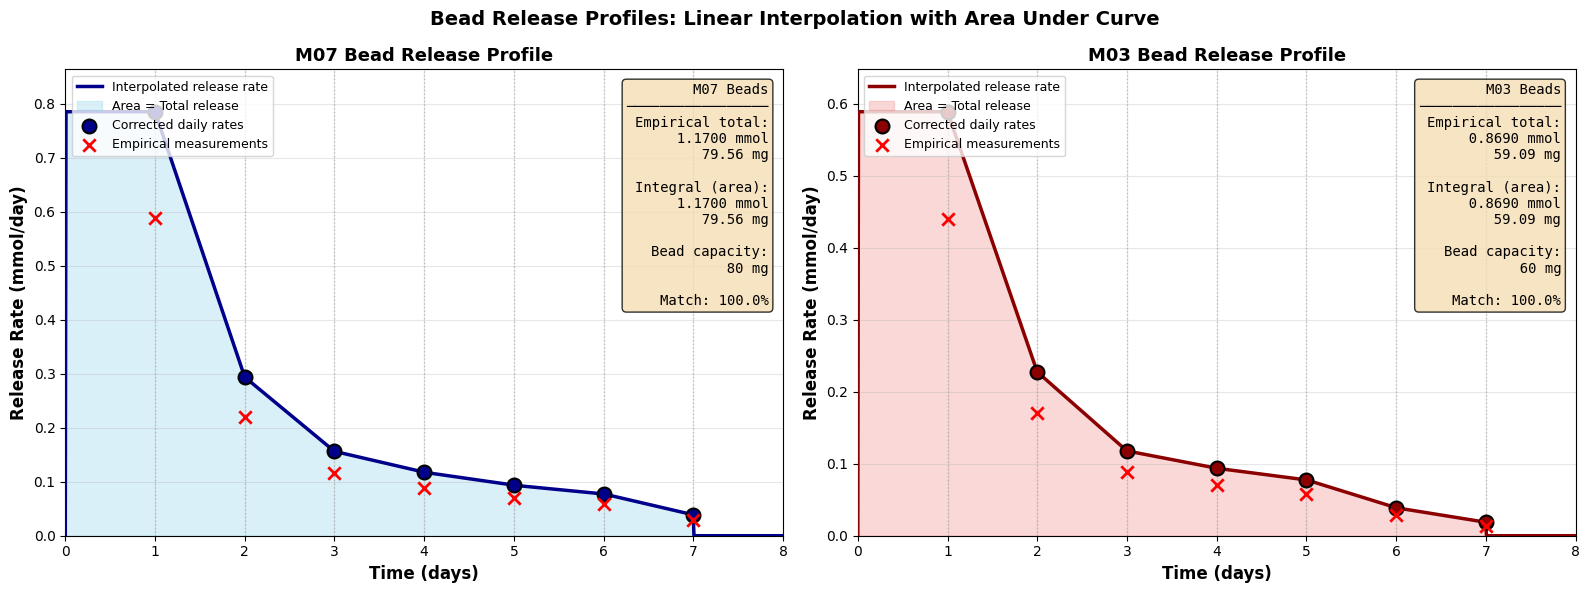


✓ Release profile visualizations generated!
  • Shaded area represents the integral (total formate released)
  • Blue/Red dots show corrected rates for linear interpolation
  • Red X markers show original empirical measurements
  • The integral exactly matches the empirical total formate content


In [88]:
# Visualize the interpolated release profiles and area under curve
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Bead Release Profiles: Linear Interpolation with Area Under Curve', 
             fontsize=14, fontweight='bold')

def plot_release_with_area(ax, release_profile, empirical_profile, bead_name, 
                           formate_content, color_fill, color_line):
    """
    Plot the interpolated release rate curve with shaded area showing integral.
    """
    days = sorted(release_profile.keys())
    
    # Create high-resolution time array for smooth curve
    time_fine = np.linspace(0, 8, 1000)
    rates_fine = []
    
    for t in time_fine:
        if t <= 0 or t > 7:
            rates_fine.append(0)
        else:
            # Linear interpolation
            day_floor = int(np.floor(t))
            day_ceil = int(np.ceil(t))
            
            if day_floor == day_ceil or day_floor < 1:
                day_floor = max(1, day_floor)
                rates_fine.append(release_profile.get(day_floor, 0))
            elif day_ceil > 7:
                rates_fine.append(0)
            else:
                rate_floor = release_profile.get(day_floor, 0)
                rate_ceil = release_profile.get(day_ceil, 0)
                fraction = t - day_floor
                rates_fine.append(rate_floor + fraction * (rate_ceil - rate_floor))
    
    # Plot the smooth interpolated curve
    ax.plot(time_fine, rates_fine, color=color_line, linewidth=2.5, 
            label='Interpolated release rate', zorder=3)
    
    # Fill area under curve (the integral)
    ax.fill_between(time_fine, 0, rates_fine, alpha=0.3, color=color_fill, 
                    label='Area = Total release', zorder=1)
    
    # Plot corrected daily values as points
    day_values = [release_profile[d] for d in days]
    ax.scatter(days, day_values, color=color_line, s=100, zorder=4, 
              edgecolors='black', linewidths=1.5, label='Corrected daily rates')
    
    # Plot empirical values as comparison
    empirical_values = [empirical_profile[d] for d in days]
    ax.scatter(days, empirical_values, color='red', s=80, zorder=5, 
              marker='x', linewidths=2, label='Empirical measurements')
    
    # Add vertical lines at day boundaries to show daily segments
    for day in range(1, 8):
        ax.axvline(x=day, color='gray', linestyle=':', alpha=0.4, linewidth=1)
    
    # Calculate integral and convert to mg
    integral_mmol = 0.0
    for i in range(len(days) - 1):
        day1, day2 = days[i], days[i + 1]
        rate1, rate2 = release_profile[day1], release_profile[day2]
        integral_mmol += 0.5 * (rate1 + rate2) * (day2 - day1)
    # Add final triangle
    integral_mmol += 0.5 * release_profile[days[-1]] * 1
    
    integral_mg = integral_mmol * FORMATE_MW
    empirical_sum_mmol = sum(empirical_profile.values())
    empirical_sum_mg = empirical_sum_mmol * FORMATE_MW
    
    # Add text box with summary
    textstr = f'{bead_name} Beads\n'
    textstr += f'─────────────────\n'
    textstr += f'Empirical total:\n'
    textstr += f'  {empirical_sum_mmol:.4f} mmol\n'
    textstr += f'  {empirical_sum_mg:.2f} mg\n\n'
    textstr += f'Integral (area):\n'
    textstr += f'  {integral_mmol:.4f} mmol\n'
    textstr += f'  {integral_mg:.2f} mg\n\n'
    textstr += f'Bead capacity:\n'
    textstr += f'  {formate_content} mg\n\n'
    textstr += f'Match: {integral_mg/empirical_sum_mg*100:.1f}%'
    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
    ax.text(0.98, 0.97, textstr, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', horizontalalignment='right', 
            bbox=props, family='monospace')
    
    ax.set_xlabel('Time (days)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Release Rate (mmol/day)', fontsize=12, fontweight='bold')
    ax.set_title(f'{bead_name} Bead Release Profile', fontsize=13, fontweight='bold')
    ax.legend(loc='upper left', fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0, 8)
    ax.set_ylim(0, max(release_profile.values()) * 1.1)

# Plot M07 beads
plot_release_with_area(axes[0], M07_BEAD_RELEASE, M07_EMPIRICAL, 'M07', 
                       M07_FORMATE_CONTENT, 'skyblue', 'darkblue')

# Plot M03 beads
plot_release_with_area(axes[1], M03_BEAD_RELEASE, M03_EMPIRICAL, 'M03', 
                       M03_FORMATE_CONTENT, 'lightcoral', 'darkred')

plt.tight_layout()
plt.show()

print("\n✓ Release profile visualizations generated!")
print("  • Shaded area represents the integral (total formate released)")
print("  • Blue/Red dots show corrected rates for linear interpolation")
print("  • Red X markers show original empirical measurements")
print("  • The integral exactly matches the empirical total formate content")

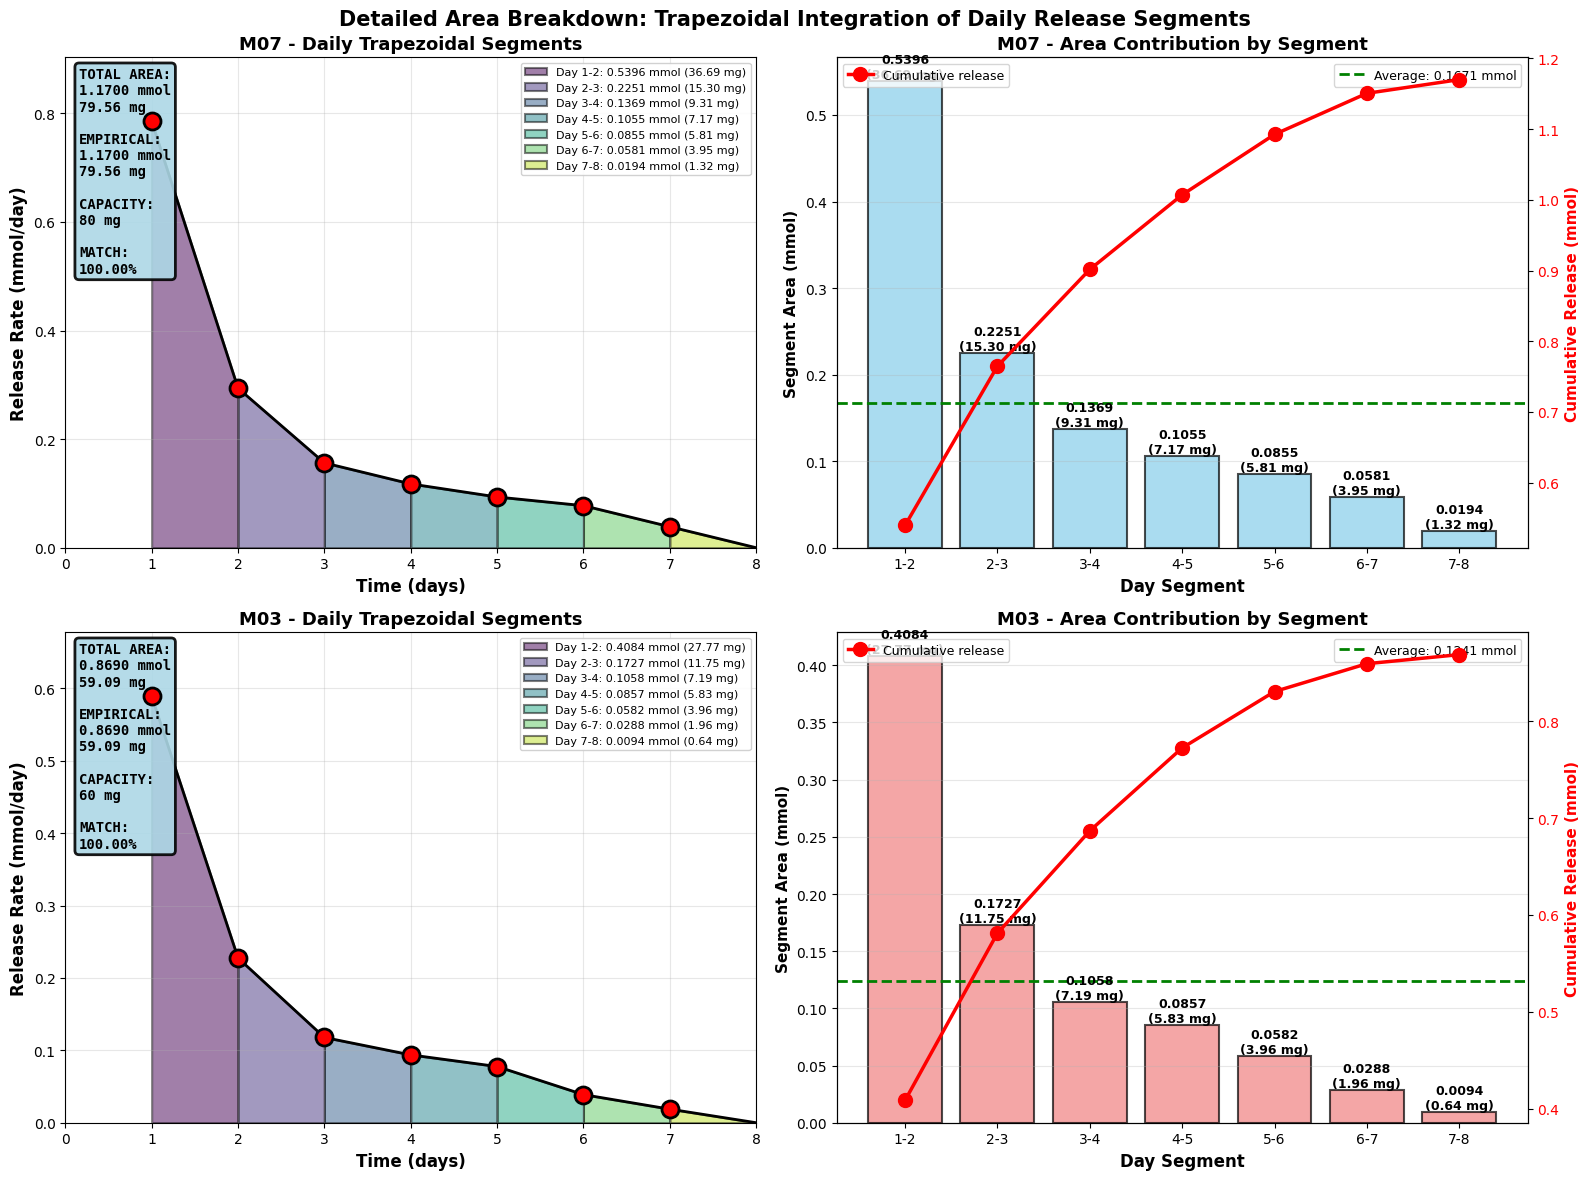


✓ Detailed area breakdown generated!
  • Left plots show each daily trapezoidal segment with its area
  • Right plots show bar charts of area contribution per segment
  • Cumulative red line shows progressive formate release
  • Total area under all segments = empirical formate content


In [89]:
# Create detailed breakdown showing area for each daily segment
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Detailed Area Breakdown: Trapezoidal Integration of Daily Release Segments', 
             fontsize=15, fontweight='bold')

def plot_daily_segments(ax, release_profile, empirical_profile, bead_name, formate_content):
    """
    Plot each daily segment with its trapezoidal area highlighted.
    """
    days = sorted(release_profile.keys())
    
    # Create color map for different days
    colors = plt.cm.viridis(np.linspace(0, 0.9, len(days)))
    
    # Calculate and plot each daily segment
    daily_areas_mmol = []
    daily_areas_mg = []
    
    for i in range(len(days) - 1):
        day1, day2 = days[i], days[i + 1]
        rate1, rate2 = release_profile[day1], release_profile[day2]
        
        # Trapezoidal area for this segment
        area_mmol = 0.5 * (rate1 + rate2) * (day2 - day1)
        area_mg = area_mmol * FORMATE_MW
        daily_areas_mmol.append(area_mmol)
        daily_areas_mg.append(area_mg)
        
        # Plot the trapezoid
        time_segment = [day1, day2]
        rate_segment = [rate1, rate2]
        
        ax.fill_between(time_segment, 0, rate_segment, 
                       alpha=0.5, color=colors[i], 
                       label=f'Day {day1}-{day2}: {area_mmol:.4f} mmol ({area_mg:.2f} mg)',
                       edgecolor='black', linewidth=1.5)
        
        ax.plot(time_segment, rate_segment, color='black', linewidth=2, zorder=3)
    
    # Add final triangle (day 7 to 0)
    last_day = days[-1]
    last_rate = release_profile[last_day]
    final_area_mmol = 0.5 * last_rate * 1
    final_area_mg = final_area_mmol * FORMATE_MW
    daily_areas_mmol.append(final_area_mmol)
    daily_areas_mg.append(final_area_mg)
    
    ax.fill_between([last_day, last_day + 1], 0, [last_rate, 0], 
                   alpha=0.5, color=colors[-1], 
                   label=f'Day {last_day}-{last_day+1}: {final_area_mmol:.4f} mmol ({final_area_mg:.2f} mg)',
                   edgecolor='black', linewidth=1.5)
    ax.plot([last_day, last_day + 1], [last_rate, 0], color='black', linewidth=2, zorder=3)
    
    # Plot corrected rates as points
    day_values = [release_profile[d] for d in days]
    ax.scatter(days, day_values, color='red', s=150, zorder=4, 
              edgecolors='black', linewidths=2, marker='o')
    
    # Calculate totals
    total_mmol = sum(daily_areas_mmol)
    total_mg = sum(daily_areas_mg)
    empirical_mmol = sum(empirical_profile.values())
    empirical_mg = empirical_mmol * FORMATE_MW
    
    ax.set_xlabel('Time (days)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Release Rate (mmol/day)', fontsize=12, fontweight='bold')
    ax.set_title(f'{bead_name} - Daily Trapezoidal Segments', fontsize=13, fontweight='bold')
    ax.legend(loc='upper right', fontsize=8, framealpha=0.9)
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0, 8)
    ax.set_ylim(0, max(release_profile.values()) * 1.15)
    
    # Add summary text
    textstr = f'TOTAL AREA:\n'
    textstr += f'{total_mmol:.4f} mmol\n'
    textstr += f'{total_mg:.2f} mg\n\n'
    textstr += f'EMPIRICAL:\n'
    textstr += f'{empirical_mmol:.4f} mmol\n'
    textstr += f'{empirical_mg:.2f} mg\n\n'
    textstr += f'CAPACITY:\n'
    textstr += f'{formate_content} mg\n\n'
    textstr += f'MATCH:\n'
    textstr += f'{total_mg/empirical_mg*100:.2f}%'
    
    props = dict(boxstyle='round', facecolor='lightblue', alpha=0.9, edgecolor='black', linewidth=2)
    ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', horizontalalignment='left', 
            bbox=props, family='monospace', fontweight='bold')
    
    return daily_areas_mmol, daily_areas_mg

def plot_area_bars(ax, daily_areas_mmol, daily_areas_mg, bead_name, color):
    """
    Create bar chart showing contribution of each daily segment.
    """
    n_segments = len(daily_areas_mmol)
    x = np.arange(n_segments)
    
    # Create bars
    bars = ax.bar(x, daily_areas_mmol, color=color, edgecolor='black', 
                   linewidth=1.5, alpha=0.7)
    
    # Add value labels on bars
    for i, (bar, mmol, mg) in enumerate(zip(bars, daily_areas_mmol, daily_areas_mg)):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{mmol:.4f}\n({mg:.2f} mg)',
                ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    # Add cumulative line
    cumulative = np.cumsum(daily_areas_mmol)
    ax2 = ax.twinx()
    ax2.plot(x, cumulative, 'ro-', linewidth=2.5, markersize=10, 
             label='Cumulative release', zorder=5)
    ax2.set_ylabel('Cumulative Release (mmol)', fontsize=11, fontweight='bold', color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    ax2.legend(loc='upper left', fontsize=9)
    
    segment_labels = [f'{i+1}-{i+2}' for i in range(n_segments-1)] + [f'{n_segments}-{n_segments+1}']
    ax.set_xlabel('Day Segment', fontsize=12, fontweight='bold')
    ax.set_ylabel('Segment Area (mmol)', fontsize=11, fontweight='bold')
    ax.set_title(f'{bead_name} - Area Contribution by Segment', fontsize=13, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(segment_labels)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add total line
    total = sum(daily_areas_mmol)
    ax.axhline(y=total/n_segments, color='green', linestyle='--', linewidth=2, 
               label=f'Average: {total/n_segments:.4f} mmol')
    ax.legend(loc='upper right', fontsize=9)

# Plot M07 segments and bars
m07_areas_mmol, m07_areas_mg = plot_daily_segments(
    axes[0, 0], M07_BEAD_RELEASE, M07_EMPIRICAL, 'M07', M07_FORMATE_CONTENT
)
plot_area_bars(axes[0, 1], m07_areas_mmol, m07_areas_mg, 'M07', 'skyblue')

# Plot M03 segments and bars
m03_areas_mmol, m03_areas_mg = plot_daily_segments(
    axes[1, 0], M03_BEAD_RELEASE, M03_EMPIRICAL, 'M03', M03_FORMATE_CONTENT
)
plot_area_bars(axes[1, 1], m03_areas_mmol, m03_areas_mg, 'M03', 'lightcoral')

plt.tight_layout()
plt.show()

print("\n✓ Detailed area breakdown generated!")
print("  • Left plots show each daily trapezoidal segment with its area")
print("  • Right plots show bar charts of area contribution per segment")
print("  • Cumulative red line shows progressive formate release")
print("  • Total area under all segments = empirical formate content")

In [90]:
class Bead:
    """
    Represents a single formate-releasing bead with continuous release kinetics.
    
    Attributes:
        bead_type (str): Type of bead ('M07' or 'M03')
        age (float): Current age of the bead in days (can be fractional)
        release_profile (dict): Daily release rates for this bead type
        day_added (float): The day this bead was added to the experiment
    """
    
    def __init__(self, bead_type, day_added=0):
        """
        Initialize a bead with a specific type.
        
        Args:
            bead_type (str): 'M07' or 'M03'
            day_added (float): The day this bead was added (for age tracking)
        """
        self.bead_type = bead_type
        self.day_added = day_added
        
        # Select the appropriate release profile
        if bead_type == 'M07':
            self.release_profile = M07_BEAD_RELEASE
        elif bead_type == 'M03':
            self.release_profile = M03_BEAD_RELEASE
        else:
            raise ValueError(f"Unknown bead type: {bead_type}")
    
    def get_release_rate(self, current_time):
        """
        Get the formate release rate at a specific time using linear interpolation.
        
        This provides smooth transitions between daily values rather than step changes.
        For example, at day 1.5, the release rate will be halfway between day 1 and day 2 values.
        
        Args:
            current_time (float): Current time in days since experiment start
            
        Returns:
            float: Release rate in mmol/day (0 if bead is exhausted)
        """
        # Calculate bead age
        bead_age = current_time - self.day_added
        
        # If bead hasn't been added yet or is exhausted, return 0
        if bead_age <= 0:
            return 0.0
        
        max_day = max(self.release_profile.keys())
        if bead_age > max_day:
            return 0.0
        
        # Get the integer day boundaries for interpolation
        day_floor = int(np.floor(bead_age))
        day_ceil = int(np.ceil(bead_age))
        
        # Handle edge case where we're exactly on a day boundary
        if day_floor == day_ceil:
            return self.release_profile.get(day_floor, 0.0)
        
        # Linear interpolation between two daily values
        if day_floor < 1:
            day_floor = 1
        if day_ceil > max_day:
            return 0.0
        
        rate_floor = self.release_profile.get(day_floor, 0.0)
        rate_ceil = self.release_profile.get(day_ceil, 0.0)
        
        # Calculate fractional part for interpolation
        fraction = bead_age - day_floor
        
        # Linear interpolation: rate = rate_floor + fraction * (rate_ceil - rate_floor)
        interpolated_rate = rate_floor + fraction * (rate_ceil - rate_floor)
        
        return interpolated_rate

print("✓ Bead class defined with linear interpolation for smooth release kinetics")

✓ Bead class defined with linear interpolation for smooth release kinetics


In [91]:
class ExperimentManager:
    """
    Manages all beads in the formate-release experiment.
    
    Attributes:
        beads (list): List of all Bead objects in the experiment
    """
    
    def __init__(self):
        """Initialize an empty experiment with no beads."""
        self.beads = []
    
    def add_bead(self, bead_type, day_added):
        """
        Add a new bead to the experiment.
        
        Args:
            bead_type (str): 'M07' or 'M03'
            day_added (float): The day this bead is added (for age tracking)
        """
        new_bead = Bead(bead_type, day_added)
        self.beads.append(new_bead)
    
    def get_total_release(self, current_time):
        """
        Calculate total formate release from all beads at a specific time.
        
        Args:
            current_time (float): Current time in days
            
        Returns:
            float: Total release rate in mmol/day
        """
        total = sum(bead.get_release_rate(current_time) for bead in self.beads)
        return total

print("✓ ExperimentManager class defined")

✓ ExperimentManager class defined


In [104]:
class MonodKinetics:
    """
    Models bacterial growth and formate consumption using Monod kinetics.
    
    Key equations:
    - Growth rate: μ = μ_max * S / (K_s + S)
    - Consumption rate: dS/dt = -μ * X / Y_xs
    
    Attributes:
        mu_max (float): Maximum specific growth rate (1/day)
        K_s (float): Half-saturation constant (mmol/L)
        Y_xs (float): Yield coefficient (OD per mmol/L substrate)
    
    """
    
    def __init__(self, mu_max, K_s, Y_xs):
        """
        Initialize Monod kinetics parameters.
        
        Args:
            mu_max (float): Maximum growth rate (1/day)
            K_s (float): Half-saturation constant (mmol/L)
            Y_xs (float): Yield coefficient (OD per mmol/L)
        """
        self.mu_max = mu_max
        self.K_s = K_s
        self.Y_xs = Y_xs
    
    def growth_rate(self, S):
        """
        Calculate specific growth rate at given substrate concentration.
        
        Args:
            S (float): Substrate concentration (mmol/L)
            
        Returns:
            float: Specific growth rate μ (1/day)
        """
        if S <= 0:
            return 0
        return self.mu_max * S / (self.K_s + S)
    
    def consumption_rate(self, S, X):
        """
        Calculate substrate consumption rate.
        
        Args:
            S (float): Substrate concentration (mmol/L)
            X (float): Bacterial concentration (OD)
            
        Returns:
            float: Consumption rate (mmol/L/day)
        """
        mu = self.growth_rate(S)
        return mu * X / self.Y_xs

print("✓ MonodKinetics class defined")

✓ MonodKinetics class defined


In [114]:
class ConstantSubstrateCalculator:
    """
    Integrated model for maintaining constant substrate concentration.
    
    This class combines:
    1. Bead release kinetics (from ExperimentManager)
    2. Bacterial consumption (from MonodKinetics)
    3. Automatic bead scheduling to maintain target substrate level
    
    Attributes:
        volume (float): Culture volume (L)
        monod (MonodKinetics): Bacterial growth model
        target_concentration (float): Desired substrate concentration (mmol/L)
        tolerance (float): Acceptable deviation from target (mmol/L)
    """
    
    def __init__(self, volume, monod_params, target_concentration, tolerance=0.1):
        """
        Initialize the integrated calculator.
        
        Args:
            volume (float): Culture volume in liters
            monod_params (dict): {'mu_max', 'K_s', 'Y_xs'} for MonodKinetics
            target_concentration (float): Target substrate concentration (mmol/L)
            tolerance (float): Acceptable deviation as fraction (e.g., 0.1 = ±10%)
        """
        self.volume = volume
        self.monod = MonodKinetics(**monod_params)
        self.target_concentration = target_concentration
        self.tolerance = tolerance
    
    def calculate_bead_schedule(self, initial_od, experiment_days=7, dt=0.01):
        """
        Calculate optimal bead addition schedule with dynamic bacterial growth.
        
        Bacterial growth is calculated using Monod kinetics based on substrate availability.
        Both substrate and bacterial density are solved dynamically in the simulation.
        
        Args:
            initial_od (float): Initial bacterial optical density
            experiment_days (int): Total experiment duration in days
            dt (float): Time step for simulation (days, default=0.01 for accuracy)
            
        Returns:
            dict: Results containing:
                - 'times': Array of time points
                - 'substrate': Substrate concentration over time
                - 'od': Bacterial density over time (calculated dynamically)
                - 'bead_schedule': {day: {'M07': count, 'M03': count}}
                - 'release_rates': Total formate release rate over time
        """
        # Initialize experiment manager
        manager = ExperimentManager()
        
        # Add initial beads to establish target concentration
        # Calculate initial consumption rate (conservative - no buffer for lag phase)
        initial_consumption = self.monod.consumption_rate(self.target_concentration, initial_od)
        initial_needed_mmol_per_day = initial_consumption * self.volume
        
        # Calculate proportional distribution
        m07_total_release = sum(M07_BEAD_RELEASE.values())
        m03_total_release = sum(M03_BEAD_RELEASE.values())
        total_capacity = m07_total_release + m03_total_release
        m07_fraction = m07_total_release / total_capacity
        m03_fraction = m03_total_release / total_capacity
        
        # Distribute initial beads proportionally (no extra buffer)
        initial_m07 = max(1, int(np.ceil(initial_needed_mmol_per_day * m07_fraction / m07_total_release)))
        initial_m03 = max(1, int(np.ceil(initial_needed_mmol_per_day * m03_fraction / m03_total_release)))
        
        for _ in range(initial_m07):
            manager.add_bead('M07', 0)
        for _ in range(initial_m03):
            manager.add_bead('M03', 0)
        
        # Simulation arrays
        times = np.arange(0, experiment_days + dt, dt)
        substrate = np.zeros_like(times)
        od = np.zeros_like(times)
        release_rates = np.zeros_like(times)
        
        # Initialize conditions
        substrate[0] = self.target_concentration
        od[0] = initial_od
        
        # Track bead additions (record initial beads)
        bead_schedule = {0: {'M07': initial_m07, 'M03': initial_m03}}
        
        # Calculate tolerance bounds for symmetric oscillations
        # Lower bound: 0.85x target (allows 15% undershoot)
        # Upper bound: 1.15x target (allows 15% overshoot)
        # This creates symmetric cycling around the target concentration
        lower_bound = self.target_concentration * 0.85
        upper_bound = self.target_concentration * 1.15
        
        # Simulate with fine time resolution - fully coupled dynamics
        for i in range(1, len(times)):
            current_time = times[i]
            current_day = int(current_time)
            
            # Get current release rate from all beads (with continuous interpolation)
            release_rate = manager.get_total_release(current_time)  # mmol/day
            release_rates[i] = release_rate
            
            # Calculate bacterial growth rate from Monod kinetics (based on ACTUAL substrate)
            mu = self.monod.growth_rate(substrate[i-1])  # 1/day
            
            # Calculate substrate consumption rate
            consumption_rate = self.monod.consumption_rate(substrate[i-1], od[i-1])  # mmol/L/day
            
            # Update bacterial density: dOD/dt = μ * OD
            dOD_dt = mu * od[i-1]
            od[i] = od[i-1] + dOD_dt * dt
            
            # Update substrate concentration: dS/dt = (release / volume) - consumption
            dS_dt = (release_rate / self.volume) - consumption_rate
            substrate[i] = substrate[i-1] + dS_dt * dt
            
            # Ensure non-negative values
            substrate[i] = max(0, substrate[i])
            od[i] = max(0, od[i])
            
            # Check if we need to add beads (at day boundaries OR when substrate drops)
            # Check every 0.5 days instead of only at day boundaries
            time_fraction = current_time - int(current_time)
            should_check = (abs(time_fraction) < dt/2 or abs(time_fraction - 0.5) < dt/2) and current_time > 0
            # Check if we need to add beads (at day boundaries only - once per day)
            if abs(current_time - current_day) < dt/2 and current_day > 0:
                # Check if substrate is below target OR approaching lower bound
                # Add beads unless substrate is extremely high (>1.5x target)
                if substrate[i] < upper_bound:
                    # Substrate not too high - consider adding beads
                    deficit_concentration = self.target_concentration - substrate[i]  # mmol/L
                    deficit = deficit_concentration * self.volume  # mmol
                    
                    # Predictive consumption: estimate average consumption for next 2-3 days
                    # This looks ahead to anticipate bacterial growth
                    predicted_od_tomorrow = od[i] * (1 + self.monod.growth_rate(self.target_concentration))
                    predicted_od_day_after = predicted_od_tomorrow * (1 + self.monod.growth_rate(self.target_concentration))
                    
                    # Average predicted consumption over next 2 days
                    consumption_today = self.monod.consumption_rate(self.target_concentration, od[i])
                    consumption_tomorrow = self.monod.consumption_rate(self.target_concentration, predicted_od_tomorrow)
                    consumption_day_after = self.monod.consumption_rate(self.target_concentration, predicted_od_day_after)
                    
                    avg_future_consumption = (consumption_today + consumption_tomorrow + consumption_day_after) / 3
                    daily_consumption = avg_future_consumption * self.volume  # mmol/day
                    
                    # Total needed: restore deficit + sustain for full day with predictive buffer
                    total_needed = deficit + daily_consumption * 1.0  # Full day of predicted consumption
                    
                    # Determine how many beads to add
                    m07_needed = 0
                    m03_needed = 0
                    m07_fraction = m07_total_release / total_capacity
                    # Strategy: Use both bead types proportionally based on their release profiles
                    # Calculate total release capacity for each bead type
                    m07_total_release = sum(M07_BEAD_RELEASE.values())
                    m03_total_release = sum(M03_BEAD_RELEASE.values())
                    
                    # Distribute the needed amount between both bead types proportionally
                    # Ratio based on their release capacities
                    total_capacity = m07_total_release + m03_total_release
                    m07_fraction = m07_total_release / total_capacity
                    m03_fraction = m03_total_release / total_capacity
                    
                    # Calculate how much each bead type should provide
                    m07_share = total_needed * m07_fraction
                    m03_share = total_needed * m03_fraction
                    
                    # Convert to bead counts (round up to ensure we meet the need)
                    m07_needed = max(1, int(np.ceil(m07_share / m07_total_release)))
                    m03_needed = max(1, int(np.ceil(m03_share / m03_total_release)))
                    
                    # Add beads at the current day
                    for _ in range(m07_needed):
                        manager.add_bead('M07', current_day)
                    for _ in range(m03_needed):
                        manager.add_bead('M03', current_day)
                    
                    # Record in schedule
                    if current_day in bead_schedule:
                        bead_schedule[current_day]['M07'] += m07_needed
                        bead_schedule[current_day]['M03'] += m03_needed
                    else:
                        bead_schedule[current_day] = {'M07': m07_needed, 'M03': m03_needed}
                
                elif substrate[i] > upper_bound:
                    # Substrate too high - no action (just let it be consumed)
                    # Could implement bead removal or waiting, but typically not needed
                    pass
        
        return {
            'times': times,
            'substrate': substrate,
            'od': od,
            'bead_schedule': bead_schedule,
            'release_rates': release_rates
        }

In [115]:
# Create the integrated calculator
calculator = ConstantSubstrateCalculator(
    volume=VOLUME,
    monod_params=MONOD_PARAMS,
    target_concentration=TARGET_CONCENTRATION,
    tolerance=TOLERANCE
)

# Run the simulation with dynamic bacterial growth
print("Running fully coupled simulation...")
print("  • Bacterial growth calculated dynamically via Monod kinetics")
print("  • Substrate dynamics respond to both bead release and bacterial consumption")
print("  • Time resolution: dt=0.01 days (high accuracy)")
print()
results = calculator.calculate_bead_schedule(
    initial_od=INITIAL_OD,
    experiment_days=EXPERIMENT_DAYS,
    dt=SIMULATION_DT
)

# Display bead schedule
print("\n✓ Simulation complete!")
print("\nBead Addition Schedule:")
print("-" * 40)
if results['bead_schedule']:
    for day, beads in sorted(results['bead_schedule'].items()):
        m07 = beads.get('M07', 0)
        m03 = beads.get('M03', 0)
        print(f"Day {day}: Add {m07} M07 beads, {m03} M03 beads")
else:
    print("No beads needed (substrate remains stable)")

# Calculate total beads used
total_m07 = sum(b.get('M07', 0) for b in results['bead_schedule'].values())
total_m03 = sum(b.get('M03', 0) for b in results['bead_schedule'].values())
print(f"\nTotal beads: {total_m07} M07, {total_m03} M03")
print(f"Final bacterial OD: {results['od'][-1]:.3f}")

Running fully coupled simulation...
  • Bacterial growth calculated dynamically via Monod kinetics
  • Substrate dynamics respond to both bead release and bacterial consumption
  • Time resolution: dt=0.01 days (high accuracy)


✓ Simulation complete!

Bead Addition Schedule:
----------------------------------------
Day 0: Add 2 M07 beads, 2 M03 beads
Day 1: Add 4 M07 beads, 4 M03 beads
Day 2: Add 5 M07 beads, 5 M03 beads
Day 3: Add 8 M07 beads, 8 M03 beads
Day 4: Add 14 M07 beads, 14 M03 beads
Day 5: Add 23 M07 beads, 23 M03 beads
Day 6: Add 39 M07 beads, 39 M03 beads
Day 7: Add 64 M07 beads, 64 M03 beads

Total beads: 159 M07, 159 M03
Final bacterial OD: 3.543


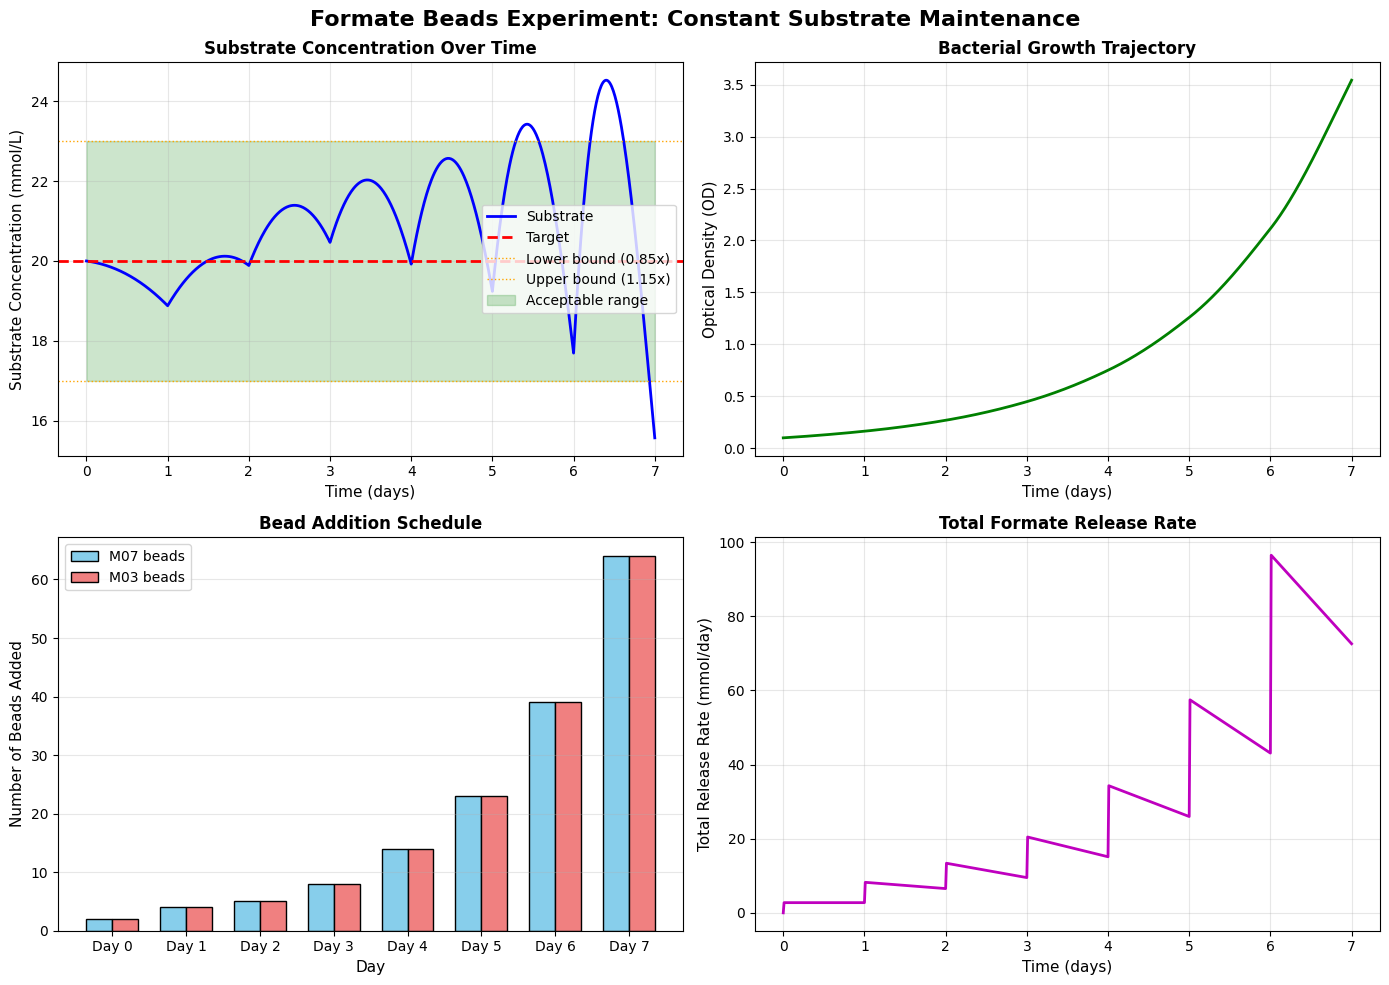


✓ Plots generated successfully!


In [118]:
# Create figure with 4 subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Formate Beads Experiment: Constant Substrate Maintenance', fontsize=16, fontweight='bold')

# Plot 1: Substrate Concentration
ax1 = axes[0, 0]
ax1.plot(results['times'], results['substrate'], 'b-', linewidth=2, label='Substrate')
ax1.axhline(y=TARGET_CONCENTRATION, color='r', linestyle='--', linewidth=2, label='Target')
# Show actual algorithm bounds (0.85x - 1.15x for symmetric oscillations)
lower_bound = TARGET_CONCENTRATION * 0.85
upper_bound = TARGET_CONCENTRATION * 1.15
ax1.axhline(y=lower_bound, color='orange', linestyle=':', linewidth=1, label='Lower bound (0.85x)')
ax1.axhline(y=upper_bound, color='orange', linestyle=':', linewidth=1, label='Upper bound (1.15x)')
ax1.fill_between(results['times'], 
                  lower_bound, 
                  upper_bound, 
                  alpha=0.2, color='green', label='Acceptable range')
ax1.set_xlabel('Time (days)', fontsize=11)
ax1.set_ylabel('Substrate Concentration (mmol/L)', fontsize=11)
ax1.set_title('Substrate Concentration Over Time', fontsize=12, fontweight='bold')
ax1.legend(loc='best')
ax1.grid(True, alpha=0.3)

# Plot 2: Bacterial Growth (OD)
ax2 = axes[0, 1]
ax2.plot(results['times'], results['od'], 'g-', linewidth=2)
ax2.set_xlabel('Time (days)', fontsize=11)
ax2.set_ylabel('Optical Density (OD)', fontsize=11)
ax2.set_title('Bacterial Growth Trajectory', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)

# Plot 3: Bead Addition Schedule
ax3 = axes[1, 0]
if results['bead_schedule']:
    days = sorted(results['bead_schedule'].keys())
    m07_counts = [results['bead_schedule'][d].get('M07', 0) for d in days]
    m03_counts = [results['bead_schedule'][d].get('M03', 0) for d in days]
    
    x = np.arange(len(days))
    width = 0.35
    
    ax3.bar(x - width/2, m07_counts, width, label='M07 beads', color='skyblue', edgecolor='black')
    ax3.bar(x + width/2, m03_counts, width, label='M03 beads', color='lightcoral', edgecolor='black')
    ax3.set_xlabel('Day', fontsize=11)
    ax3.set_ylabel('Number of Beads Added', fontsize=11)
    ax3.set_title('Bead Addition Schedule', fontsize=12, fontweight='bold')
    ax3.set_xticks(x)
    ax3.set_xticklabels([f'Day {d}' for d in days])
    ax3.legend(loc='best')
    ax3.grid(True, alpha=0.3, axis='y')
else:
    ax3.text(0.5, 0.5, 'No beads added\n(substrate stable)', 
             ha='center', va='center', fontsize=14)
    ax3.set_xlim(0, 1)
    ax3.set_ylim(0, 1)

# Plot 4: Total Release Rate
ax4 = axes[1, 1]
ax4.plot(results['times'], results['release_rates'], 'm-', linewidth=2)
ax4.set_xlabel('Time (days)', fontsize=11)
ax4.set_ylabel('Total Release Rate (mmol/day)', fontsize=11)
ax4.set_title('Total Formate Release Rate', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Plots generated successfully!")

In [31]:
# Calculate summary statistics
avg_substrate = np.mean(results['substrate'])
min_substrate = np.min(results['substrate'])
max_substrate = np.max(results['substrate'])
std_substrate = np.std(results['substrate'])

final_od = results['od'][-1]
max_release_rate = np.max(results['release_rates'])

print("=" * 50)
print("EXPERIMENT SUMMARY")
print("=" * 50)

print("\n📊 Substrate Control Performance:")
print(f"  • Target concentration: {TARGET_CONCENTRATION} mmol/L")
print(f"  • Average achieved: {avg_substrate:.2f} mmol/L")
print(f"  • Range: {min_substrate:.2f} - {max_substrate:.2f} mmol/L")
print(f"  • Standard deviation: {std_substrate:.2f} mmol/L")
print(f"  • Within tolerance: {abs(avg_substrate - TARGET_CONCENTRATION) < TOLERANCE}")

print("\n🦠 Bacterial Growth:")
print(f"  • Initial OD: {results['od'][0]:.3f}")
print(f"  • Final OD: {final_od:.3f}")
print(f"  • Growth factor: {final_od/results['od'][0]:.1f}x")

print("\n💊 Bead Usage:")
total_m07 = sum(b.get('M07', 0) for b in results['bead_schedule'].values())
total_m03 = sum(b.get('M03', 0) for b in results['bead_schedule'].values())
print(f"  • Total M07 beads: {total_m07}")
print(f"  • Total M03 beads: {total_m03}")
print(f"  • Addition events: {len(results['bead_schedule'])}")
print(f"  • Max release rate: {max_release_rate:.4f} mmol/day")

print("\n" + "=" * 50)
print("✓ Analysis complete!")
print("=" * 50)

EXPERIMENT SUMMARY

📊 Substrate Control Performance:
  • Target concentration: 10.0 mmol/L
  • Average achieved: 9.05 mmol/L
  • Range: 6.30 - 10.11 mmol/L
  • Standard deviation: 1.16 mmol/L
  • Within tolerance: False

🦠 Bacterial Growth:
  • Initial OD: 0.050
  • Final OD: 1.364
  • Growth factor: 27.3x

💊 Bead Usage:
  • Total M07 beads: 7
  • Total M03 beads: 2
  • Addition events: 4
  • Max release rate: 0.2402 mmol/day

✓ Analysis complete!


---

## How to Use This Notebook

### Quick Start:
1. **Run all cells** (Cell → Run All) to execute the complete simulation
2. **Modify parameters** in Section 7 to explore different scenarios:
   - Change `VOLUME` for different culture sizes
   - Adjust `TARGET_CONCENTRATION` for different substrate levels
   - Modify `INITIAL_OD` for different inoculation densities
   - Tune `MONOD_PARAMS` based on your bacterial strain characteristics

### Understanding the Model:

**Bead Release:**
- M07 beads: High initial release, decreasing over 7 days (good for quick substrate boost)
- M03 beads: Steady sustained release (good for maintenance)

**Monod Kinetics:**
- Models bacterial growth and substrate consumption
- Growth rate depends on substrate availability
- Consumption increases with bacterial density

**Integrated Model:**
- Fully coupled simulation: bacterial growth responds to substrate availability
- Bacterial density calculated dynamically using Monod kinetics (dOD/dt = μ × OD)
- Substrate dynamics include both bead release and bacterial consumption
- Automatically adds beads when substrate drops below target
- Balances release rate with consumption rate in real-time

### Tips:
- Start with default parameters to understand baseline behavior
- Increase `TOLERANCE` for fewer bead additions (less precise control)
- Decrease `TOLERANCE` for tighter substrate control (more beads needed)
- Adjust `INITIAL_OD` to explore how inoculation density affects bead requirements
- Higher `mu_max` or lower `Y_xs` → faster growth/consumption → more beads needed

## 10. Experiment Summary and Analysis

Summary of key results and insights from the simulation.

## 9. Visualize Results

Create comprehensive plots showing:
1. **Substrate Concentration** - How well we maintain the target level
2. **Bacterial Growth** - OD trajectory over time
3. **Bead Schedule** - When and how many beads are added
4. **Release Rates** - Total formate release from all beads

## 8. Run Simulation

Create the integrated model and calculate the optimal bead schedule to maintain constant substrate concentration throughout the experiment.

## 7. Run Simulation

Execute the integrated model using parameters from the configuration cell (Cell 2).
The simulation calculates the optimal bead schedule to maintain constant substrate concentration.

## 6. Define ConstantSubstrateCalculator Class

The `ConstantSubstrateCalculator` is the core integrated model that:
- Combines bead release kinetics with bacterial consumption
- Automatically schedules bead additions to maintain target substrate concentration
- Simulates the entire experiment using ODE integration
- Outputs detailed results including substrate levels, bacterial growth, and bead schedule

## 5. Define MonodKinetics Class

The `MonodKinetics` class models bacterial growth and formate consumption:
- Uses Monod kinetics for substrate-limited growth
- Tracks bacterial population (OD) and substrate concentration
- Calculates consumption rate based on growth rate and yield coefficient

## 4. Define ExperimentManager Class

The `ExperimentManager` manages all beads in the experiment:
- Maintains a collection of beads added on different days
- Calculates total formate release from all active beads
- Updates bead ages as time progresses

## 3. Define Bead Class

The `Bead` class represents a single formate-releasing bead. Each bead:
- Has a specific release profile (M07 or M03)
- Tracks its age (days since addition)
- Calculates current release rate based on age